<h1 style="text-align: center;" markdown="3">Machine Learning 4: Random Forest Classifier</h1> 

# Table of Contents
[Introduction](#introduction)  
[Random Forest Classifier](#rf)   
&nbsp;&nbsp;&nbsp;[Undersampling](#undersampling)  
&nbsp;&nbsp;&nbsp;[Oversampling](#oversampling)  
&nbsp;&nbsp;&nbsp;[Tune Parameters and Cross-Validate](#tune-cv)      
[Feature Selection](#feature-selection)  
[Summary](#summary)

# Introduction <a class="anchor" id="introduction"></a>

Decision trees are simple and fast but they tend to suffer from high variance and overfit the training data. Random forests mitigate this problem using a combination of bootstrap aggregation and random subspace sampling to create an ensemble - a forest - of many decorrelated trees that typically outperform any individual CART.

## Data setup

As usual, we'll load a the libraries and the data that will be used throughout this notebook. 

In [1]:
# Data importation and manipulation tools
import numpy as np
import pandas as pd
import itertools
import json

# Data visualization tools
%matplotlib inline
from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set()

# Machine Learning tools
from sklearn.linear_model import LogisticRegression

# Metrics
from sklearn.metrics import (
    confusion_matrix,
    log_loss,
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    cohen_kappa_score,
    roc_curve,
    auc
)

In [2]:
# load training data 
lcs_train = pd.read_pickle("Data/processed/train.pkl")

# Separate features
X_train = lcs_train.drop(['Persns_wgt', 'sick'], axis=1)
y_train = lcs_train['sick']
w_train = lcs_train['Persns_wgt']

# summarize loaded data
print('Data has {:,} rows and {:,} columns' \
        .format(*X_train.shape))

print('Percent sick: {:0.1%} \tPercent non-sick: {:0.1%}' \
        .format(*y_train.value_counts(normalize=True, ascending=True)))

# Load test data
lcs_test = pd.read_pickle("Data/processed/test.pkl")

# Separate features
X_test = lcs_test.drop(['Persns_wgt', 'sick'], axis=1)
y_test = lcs_test['sick']
y_test = np.ravel(y_test)
w_test = lcs_test['Persns_wgt']

# print first 5 rows of data
X_train.head()

Data has 39,075 rows and 236 columns
Percent sick: 15.9% 	Percent non-sick: 84.1%


,Q14AGE,Q613BED,Q615KITCHEN,Q616BATH,Q617TOILET,Q161APUBATT,Q161APRIVATT,hhsize,expenditure_pcp,pcnetincome,...,Q221DHEALTH__More than adequate,Q224ANOMONEY__Yes,Q224BNOMONEY5__Yes,Q225ASIZE__Yes,Q225BSIZE5__Yes,Q226ASKIP__Yes,Q226BSKIP5__Yes,Q227ALESS__Yes,Q227BLESS5__Yes,SexOfHead__Male
UQNO,,,,,,,,,,,,,,,,,,,,,
920002240000007301,48,2,0,0,0,0,0,5,3664.148804,400,...,0,0,0,0,0,0,0,0,0,1
417000450000011901,27,0,0,0,0,0,0,4,11451.292500,1250,...,0,0,0,0,0,1,0,1,0,1
107002150000030901,3,1,1,0,0,3,0,6,6066.745258,1000,...,0,1,0,1,0,1,0,1,0,1
919005240000017601,0,1,1,1,0,0,0,3,28007.446415,2620,...,0,0,0,0,0,0,0,0,0,1
983000120000022201,4,3,1,0,0,0,0,7,1727.626033,285,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# Standardize features
def standardize(df):
    cols = df.loc[:, df.dtypes != 'uint8'].columns
    for field in cols:
        mean, std = df[field].mean(), df[field].std()
        # account for constant columns
        if np.all(df[field] - mean != 0):
            df.loc[:, field] = (df[field] - mean) / std
    
    return df

standardize(X_train)
standardize(X_test)
X_train.head()

,Q14AGE,Q613BED,Q615KITCHEN,Q616BATH,Q617TOILET,Q161APUBATT,Q161APRIVATT,hhsize,expenditure_pcp,pcnetincome,...,Q221DHEALTH__More than adequate,Q224ANOMONEY__Yes,Q224BNOMONEY5__Yes,Q225ASIZE__Yes,Q225BSIZE5__Yes,Q226ASKIP__Yes,Q226BSKIP5__Yes,Q227ALESS__Yes,Q227BLESS5__Yes,SexOfHead__Male
UQNO,,,,,,,,,,,,,,,,,,,,,
920002240000007301,0.955936,-0.414011,-1.395383,-0.582252,-0.528091,-0.298658,-0.286177,-0.157885,-0.431979,-0.283026,...,0,0,0,0,0,0,0,0,0,1
417000450000011901,-0.052461,-1.779027,-1.395383,-0.582252,-0.528091,-0.298658,-0.286177,-0.489928,-0.258849,-0.141051,...,0,0,0,0,0,1,0,1,0,1
107002150000030901,-1.204916,-1.096519,0.262655,-0.582252,-0.528091,1.359649,-0.286177,0.174158,-0.378563,-0.182809,...,0,1,0,1,0,1,0,1,0,1
919005240000017601,-1.348973,-1.096519,0.262655,0.617089,-0.528091,-0.298658,-0.286177,-0.821970,0.109240,0.087779,...,0,0,0,0,0,0,0,0,0,1
983000120000022201,-1.156897,0.268497,0.262655,-0.582252,-0.528091,-0.298658,-0.286177,0.506200,-0.475034,-0.302234,...,0,0,0,0,0,0,0,0,0,0


## Metrics functions
Let's also create of functions for the evaluation of models.

In [4]:
# Create the ROC plot function
def plot_roc(y_test, y_pred, y_prob, model, ax, sample_weights=None):
    
    # dictionnary of metrics to calculate
    fpr, tpr, _ = roc_curve(y_test, y_prob, sample_weight=sample_weights)
    metrics = {}
    metrics['fpr'] = fpr
    metrics['tpr'] = tpr
    metrics['roc_auc'] = roc_auc_score(y_test,y_prob, sample_weight=sample_weights)
    
    # Create graph with Legend
    ax= ax
    ax.plot(metrics['fpr'], metrics['tpr'], label='{} AUC = {:0.2f}'.format(model, metrics['roc_auc']))
    
    # Specification of Graph
    ax.set_title('Receiver Operating Characteristic')
    ax.plot([0,1],[0,1],'k--')
    ax.set_xlim([-0.01,1])
    ax.set_ylim([0,1.01])
    ax.legend(loc='lower right')
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
    return

# Create the confusion matrix plot function
# Derived from: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

def plot_confusion_matrix(y_test, y_pred,ax, sample_weight = None):
    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred, sample_weight=None)
    # Reverse the results
    cm = cm[::-1,::-1]

    # Create plot
    ax = ax
    tick_marks = np.arange(2)
    ax.set_title('Confusion matrix')
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(["sick", "non-sick"])
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(["sick","non-sick"])
    ax.grid(False)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

    # Create font and color bar
    im = ax.imshow(cm, interpolation='nearest', cmap= plt.cm.Blues)
    fig.colorbar(im, ax=ax, shrink=0.7)

    # Create normalized and text results
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        txt = "{:.0f}".format(cm[i,j])
        txt = txt + "\n{:0.1%}".format(cm_norm[i,j])
        ax.text(j, i, txt, fontsize=14, fontweight='bold',
                     horizontalalignment="center", verticalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    return


# Create a DataFrame to store de model results
model_score = pd.DataFrame(index = ['accuracy','recall','precision','f1','roc_auc','cross_entropy','cohen_kappa'])

# Define a function to show metrics in a DataFrame
def get_metrics(y_test, y_pred, model_name, sample_weights=None): 
    # Show metrics values
    model_scores = {}

    model_scores['accuracy']          = accuracy_score(y_test, y_pred, sample_weight=sample_weights)
    model_scores['recall']            = recall_score(y_test, y_pred, sample_weight=sample_weights)
    model_scores['precision']         = precision_score(y_test, y_pred, sample_weight=sample_weights)
    model_scores['f1']                = f1_score(y_test, y_pred, sample_weight=sample_weights)
    model_scores['roc_auc']           = roc_auc_score(y_test,y_prob, sample_weight=sample_weights)
    model_scores['cross_entropy']     = log_loss(y_test,y_prob,sample_weight=sample_weights)
    model_scores['cohen_kappa']       = cohen_kappa_score(y_test, y_pred)

    print("Model Scores")
    print("Actual sick rate: {:0.2%}".format(y_test.sum()/len(y_test)))
    print("Predicted sick rate: {:0.2%}".format(y_pred.sum()/len(y_pred)))
    model_score[model_name] = model_score.index.map(model_scores)
    return model_score

# Random forest <a class="anchor" id="rf"></a>

One consideration to have with random forest is that it is straightforward to assess feature importance with trees: the earlier a feature appears as a split variable, the more important it is. Let's create a function to retrieve those features.

In [5]:
# Create DataFrame of feature importances
def get_feat_imp_df(feat_imps, index=None, sort=True):
    feat_imps = pd.DataFrame(feat_imps, columns=['importance'])
    if index is not None:
        feat_imps.index = index
    if sort:
        feat_imps = feat_imps.sort_values('importance', ascending=False)
    return feat_imps

In [6]:
from sklearn.ensemble import RandomForestClassifier

# Fit the model
model = RandomForestClassifier()
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train, w_train)
print("In-sample score: {:0.2%}".format(score))
feat_imps = get_feat_imp_df(model.feature_importances_, index=X_train.columns)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

/Users/valentinmonney/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 604 ms, sys: 31.1 ms, total: 635 ms
Wall time: 645 ms
CPU times: user 74.4 ms, sys: 783 µs, total: 75.2 ms
Wall time: 76 ms
In-sample score: 99.09%


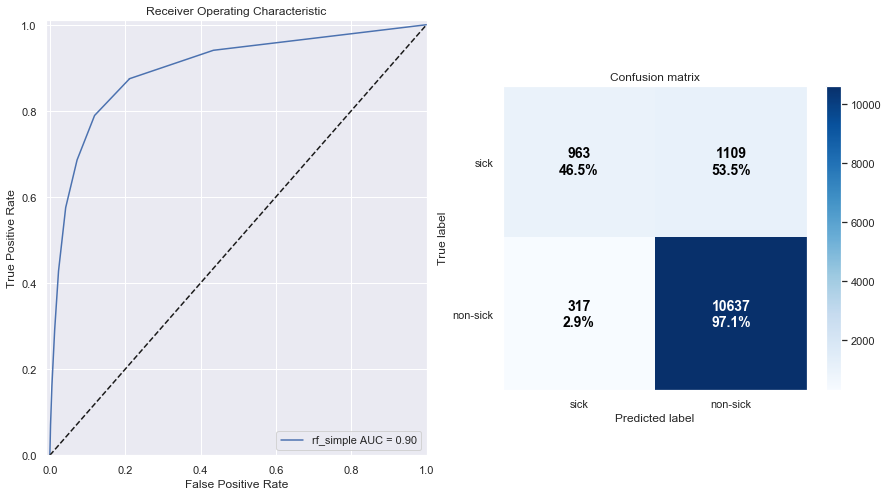

Model Scores
Actual sick rate: 15.91%
Predicted sick rate: 9.83%


,rf_simple
accuracy,0.899686
recall,0.428071
precision,0.752337
f1,0.545665
roc_auc,0.896974
cross_entropy,0.508926
cohen_kappa,0.515755


In [7]:
# Show plot of metrics
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,8))
plot_roc(y_test, y_pred, y_prob, "rf_simple", ax= axes[0], sample_weights= w_test)
plot_confusion_matrix(y_test, y_pred, ax= axes[1])
plt.show()
get_metrics(y_test, y_pred, 'rf_simple', sample_weights = w_test)

The default model gives us good accuracy. But the recall is low and the high in-sample score (99.22%) is a good indication of over-fitting. Let's modify some of the parameters to see if we can mitigate this. The random forest classifier includes the option to balance the classes with `class_weight='balanced'`, so we'll first try this before applying a sampling method.

## Class Weighting

In [8]:
# Fit the model
model = RandomForestClassifier(n_estimators=100, 
                               max_depth=20, 
                               min_samples_leaf=5, 
                               min_samples_split=5, 
                               class_weight='balanced')
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train, w_train)
print("In-sample score: {:0.2%}".format(score))
feat_imps = get_feat_imp_df(model.feature_importances_, index=X_train.columns)

# Run the model
y_pred_classwts = model.predict(X_test)
y_prob_classwts = model.predict_proba(X_test)[:,1]

CPU times: user 4.25 s, sys: 476 ms, total: 4.73 s
Wall time: 4.09 s
CPU times: user 474 ms, sys: 2.77 ms, total: 477 ms
Wall time: 477 ms
In-sample score: 91.90%


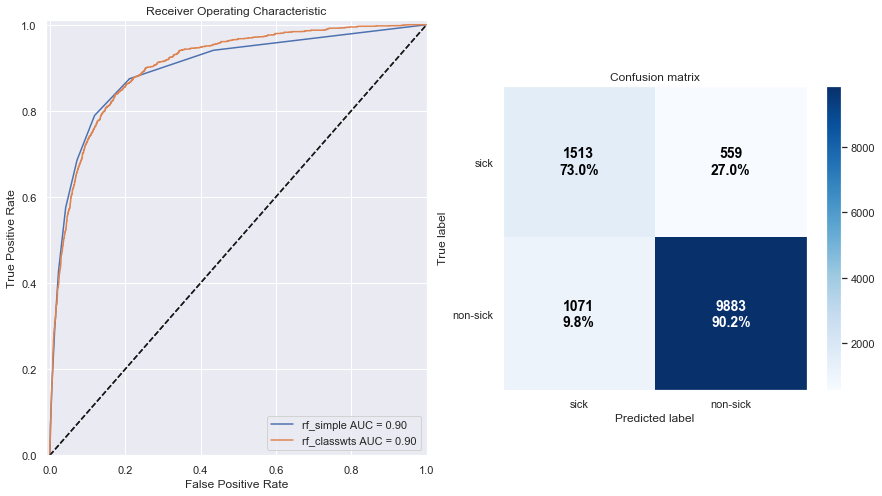

Model Scores
Actual sick rate: 15.91%
Predicted sick rate: 19.84%


,rf_simple,rf_classwts
accuracy,0.899686,0.882969
recall,0.428071,0.689926
precision,0.752337,0.569484
f1,0.545665,0.623946
roc_auc,0.896974,0.896974
cross_entropy,0.508926,0.508926
cohen_kappa,0.515755,0.574850


In [9]:
# Show plot of metrics
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,8))
plot_roc(y_test, y_pred, y_prob, "rf_simple", ax= axes[0], sample_weights= w_test)
plot_roc(y_test, y_pred_classwts, y_prob_classwts, "rf_classwts", ax= axes[0], sample_weights= w_test)
plot_confusion_matrix(y_test, y_pred_classwts, ax= axes[1])
plt.show()
get_metrics(y_test, y_pred_classwts, 'rf_classwts', sample_weights = w_test)

We get much better recall with the class weights with a trade of a bit of accuracy. The f1 metrics is much better. Overall I get better performance with class weightings.

## Undersampling <a class="anchor" id="undersampling">
Now we'll apply undersampling and see how the performance is affected.

In [10]:
from imblearn.under_sampling import RandomUnderSampler

# Apply random undersampling
X_train_u, y_train_u = RandomUnderSampler().fit_sample(X_train, y_train)
print("X shape after undersampling: ", X_train_u.shape)

# Fit the model
model = RandomForestClassifier(n_estimators=100, 
                               max_depth=20, 
                               min_samples_leaf=5, 
                               min_samples_split=5)
%time model.fit(X_train_u, y_train_u)

# Get an initial score
%time score = model.score(X_train_u, y_train_u)
print("In-sample score: {:0.2%}".format(score))
feat_imps = get_feat_imp_df(model.feature_importances_, index=X_train.columns)

# Run the model
%time y_pred_u = model.predict(X_test)
%time y_prob_u = model.predict_proba(X_test)[:,1]

Using TensorFlow backend.


X shape after undersampling:  (12430, 236)
CPU times: user 1.04 s, sys: 3 ms, total: 1.05 s
Wall time: 1.05 s
CPU times: user 132 ms, sys: 445 µs, total: 132 ms
Wall time: 132 ms
In-sample score: 87.10%
CPU times: user 143 ms, sys: 6.54 ms, total: 149 ms
Wall time: 149 ms
CPU times: user 141 ms, sys: 201 µs, total: 141 ms
Wall time: 141 ms


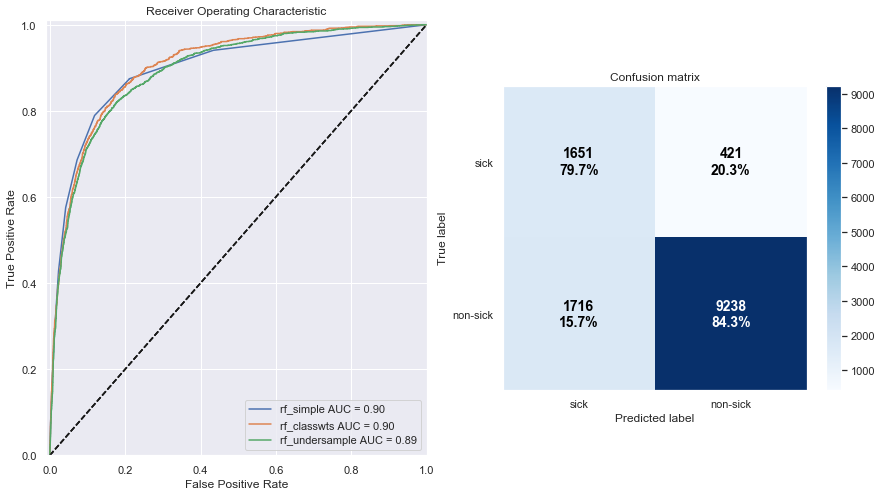

Model Scores
Actual sick rate: 15.91%
Predicted sick rate: 25.85%


,rf_simple,rf_classwts,rf_undersample
accuracy,0.899686,0.882969,0.842746
recall,0.428071,0.689926,0.766799
precision,0.752337,0.569484,0.464426
f1,0.545665,0.623946,0.578483
roc_auc,0.896974,0.896974,0.896974
cross_entropy,0.508926,0.508926,0.508926
cohen_kappa,0.515755,0.574850,0.510743


In [11]:
# Show plot of metrics
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,8))
plot_roc(y_test, y_pred, y_prob, "rf_simple", ax= axes[0], sample_weights= w_test)
plot_roc(y_test, y_pred_classwts, y_prob_classwts, "rf_classwts", ax= axes[0], sample_weights= w_test)
plot_roc(y_test, y_pred_u, y_prob_u, "rf_undersample", ax= axes[0])
plot_confusion_matrix(y_test, y_pred_u, ax= axes[1])
plt.show()
get_metrics(y_test, y_pred_u, 'rf_undersample', sample_weights = w_test)

Undersampling give less accurate prediction, but the recall is better. It is normal since we predicted 25% of people being sick although there only 16% of them. Overall, this is not the best results. This prediction would not lead to an efficient classification for doctors of South Africa. Let's try with oversampling.

## Oversampling <a class="anchor" id="oversampling">

In [12]:
from imblearn.over_sampling import SMOTE

# Apply oversampling with SMOTE
X_train_o, y_train_o = SMOTE().fit_sample(X_train, y_train)
print("X shape after undersampling: ", X_train_o.shape)

# Fit the model
model = RandomForestClassifier(n_estimators=100, 
                               max_depth=20, 
                               min_samples_leaf=5, 
                               min_samples_split=5)
%time model.fit(X_train_o, y_train_o)

# Get an initial score
%time score = model.score(X_train_o, y_train_o)
print("In-sample score: {:0.2%}".format(score))
feat_imps = get_feat_imp_df(model.feature_importances_, index=X_train.columns)

# Run the model
%time y_pred_o = model.predict(X_test)
%time y_prob_o = model.predict_proba(X_test)[:,1]

X shape after undersampling:  (65720, 236)
CPU times: user 8.63 s, sys: 46.4 ms, total: 8.68 s
Wall time: 8.68 s
CPU times: user 704 ms, sys: 7.05 ms, total: 711 ms
Wall time: 710 ms
In-sample score: 96.10%
CPU times: user 165 ms, sys: 1.22 ms, total: 167 ms
Wall time: 167 ms
CPU times: user 167 ms, sys: 1.13 ms, total: 168 ms
Wall time: 168 ms


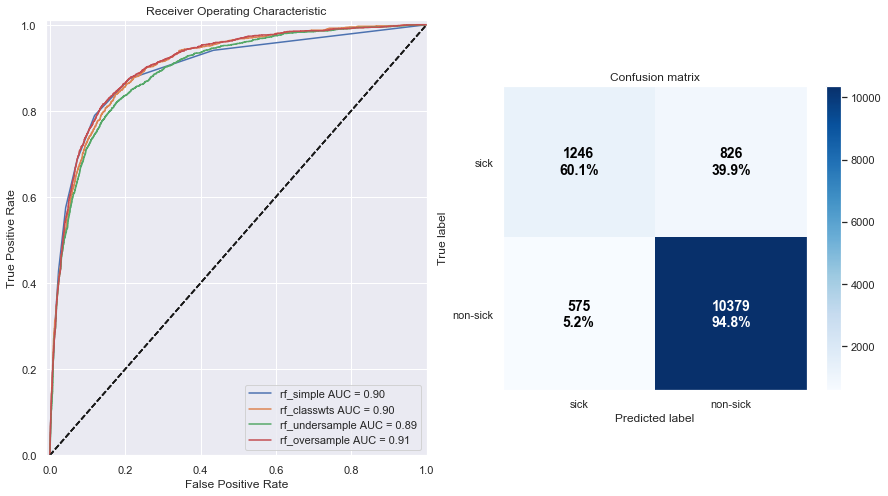

Model Scores
Actual sick rate: 15.91%
Predicted sick rate: 13.98%


,rf_simple,rf_classwts,rf_undersample,rf_oversample
accuracy,0.899686,0.882969,0.842746,0.900565
recall,0.428071,0.689926,0.766799,0.560950
precision,0.752337,0.569484,0.464426,0.677070
f1,0.545665,0.623946,0.578483,0.613564
roc_auc,0.896974,0.896974,0.896974,0.896974
cross_entropy,0.508926,0.508926,0.508926,0.508926
cohen_kappa,0.515755,0.574850,0.510743,0.577207


In [13]:
# Show plot of metrics
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,8))
plot_roc(y_test, y_pred, y_prob, "rf_simple", ax= axes[0], sample_weights= w_test)
plot_roc(y_test, y_pred_classwts, y_prob_classwts, "rf_classwts", ax= axes[0], sample_weights= w_test)
plot_roc(y_test, y_pred_u, y_prob_u, "rf_undersample", ax= axes[0])
plot_roc(y_test, y_pred_o, y_prob_o, "rf_oversample", ax= axes[0])
plot_confusion_matrix(y_test, y_pred_o, ax= axes[1])
plt.show()
get_metrics(y_test, y_pred_o, 'rf_oversample', sample_weights = w_test)

Oversampling gives better accuracy but less recall. The f1 is slightly better than the class weights. So from now on, I will use the oversampled model.

## Tune parameters and cross-validate <a class="anchor" id="tune-cv"></a>



In [14]:
from sklearn.model_selection import GridSearchCV

# build the model
estimator = RandomForestClassifier()
parameters = {'n_estimators': [10, 50, 100],
              'max_depth': np.arange(1,16,5), 
              'min_samples_split': np.arange(2,21,10),
              'min_samples_leaf': np.arange(1,46,20)
             }

model = GridSearchCV(estimator, parameters, verbose=1, cv=5, n_jobs=-1)
%time model.fit(X_train_o, y_train_o)

# Get an initial score
%time score = model.score(X_train_o, y_train_o)
print("In-sample score: {:0.2%}".format(score))
print("Best model parameters:", model.best_params_)
feat_imps = get_feat_imp_df(model.best_estimator_.feature_importances_, index=X_train.columns)

# Run the model
y_pred_cv = model.predict(X_test)
y_prob_cv = model.predict_proba(X_test)[:,1]

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  2.8min finished


CPU times: user 7.75 s, sys: 460 ms, total: 8.21 s
Wall time: 2min 53s
CPU times: user 455 ms, sys: 521 µs, total: 456 ms
Wall time: 455 ms
In-sample score: 90.88%
Best model parameters: {'max_depth': 11, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


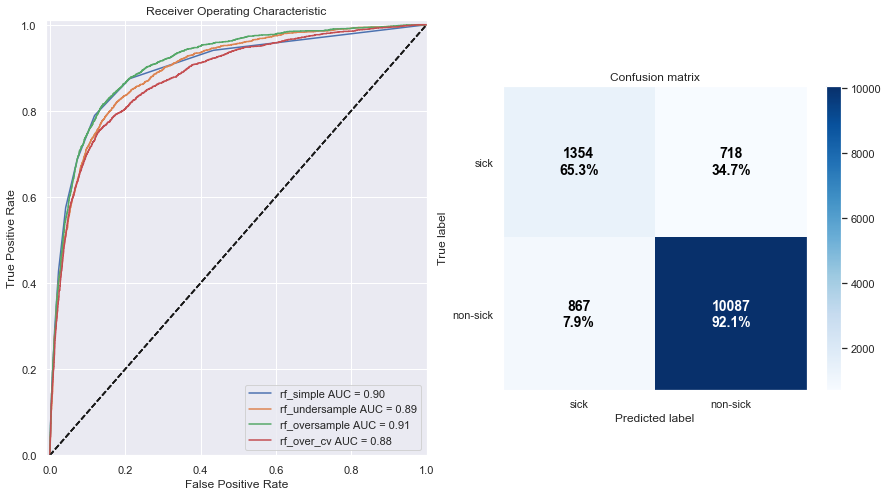

Model Scores
Actual sick rate: 15.91%
Predicted sick rate: 17.05%


,rf_simple,rf_classwts,rf_undersample,rf_oversample,rf_over_cv
accuracy,0.899686,0.882969,0.842746,0.900565,0.886942
recall,0.428071,0.689926,0.766799,0.560950,0.610015
precision,0.752337,0.569484,0.464426,0.677070,0.596045
f1,0.545665,0.623946,0.578483,0.613564,0.602949
roc_auc,0.896974,0.896974,0.896974,0.896974,0.896974
cross_entropy,0.508926,0.508926,0.508926,0.508926,0.508926
cohen_kappa,0.515755,0.574850,0.510743,0.577207,0.558056


In [15]:
# Show plot of metrics
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,8))
plot_roc(y_test, y_pred, y_prob, "rf_simple", ax= axes[0], sample_weights= w_test)
plot_roc(y_test, y_pred_u, y_prob_u, "rf_undersample", ax= axes[0])
plot_roc(y_test, y_pred_o, y_prob_o, "rf_oversample", ax= axes[0])
plot_roc(y_test, y_pred_cv, y_prob_cv, "rf_over_cv", ax= axes[0])
plot_confusion_matrix(y_test, y_pred_cv, ax= axes[1])
plt.show()

# Store the best model
best_model = model.best_estimator_

get_metrics(y_test, y_pred_cv, 'rf_over_cv', sample_weights = w_test)

Cross validation doesn't have significant impact on performance. We again tend to have better recall using undersampling, but better overall performance using oversampling.

In [16]:
# Collect results in a DataFrame
cv_results = pd.DataFrame(model.cv_results_)

# Print a few interesting columns
cols = ['mean_test_score', 
        'std_test_score', 
        'mean_train_score',
        'std_train_score', 
        'param_n_estimators',
        'param_max_depth', 
        'param_min_samples_split',
        'param_min_samples_leaf']
cv_results[cols].sort_values('mean_test_score', ascending=False)

/Users/valentinmonney/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/valentinmonney/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/valentinmonney/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=T

,mean_test_score,std_test_score,mean_train_score,std_train_score,param_n_estimators,param_max_depth,param_min_samples_split,param_min_samples_leaf
38,0.886701,0.063210,0.912622,0.018118,100,11,2,1
37,0.886306,0.063758,0.912511,0.020396,50,11,2,1
40,0.886153,0.060789,0.908445,0.019236,50,11,12,1
41,0.886047,0.061802,0.908787,0.019162,100,11,12,1
46,0.883932,0.058814,0.898079,0.018107,50,11,12,21
44,0.883384,0.058796,0.898859,0.019648,100,11,2,21
39,0.883217,0.061203,0.902286,0.015577,10,11,12,1
47,0.882684,0.059325,0.898185,0.018874,100,11,12,21
43,0.882532,0.058360,0.897158,0.018132,50,11,2,21
36,0.881939,0.062840,0.905816,0.014837,10,11,2,1


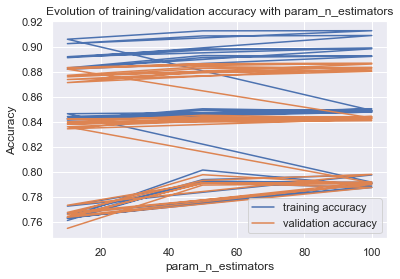

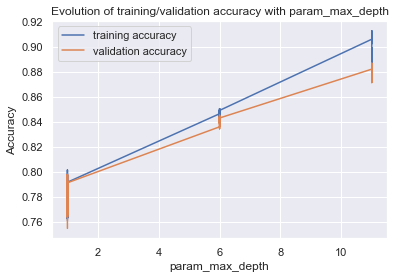

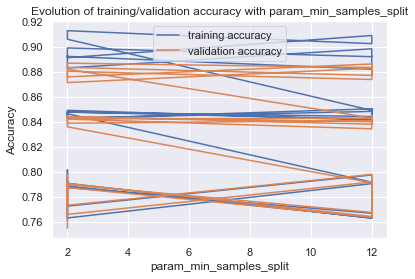

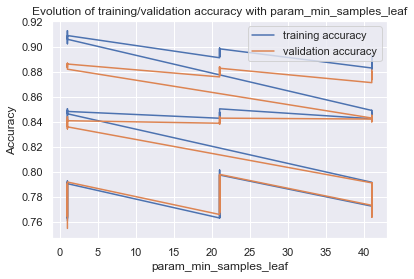

In [19]:
para = ['param_n_estimators', 'param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf']

for p in para:
    plt.plot(cv_results[p], cv_results["mean_train_score"], label='training accuracy')
    plt.plot(cv_results[p], cv_results["mean_test_score"],  label='validation accuracy')
    plt.xlabel(cv_results[p].name)
    plt.ylabel('Accuracy')
    plt.title("Evolution of training/validation accuracy with {}".format(cv_results[p].name))
    plt.legend()
    plt.show()

According to the results, the only significant parameter seems to be the max depth of trees which seem to increase accuracy with more depth. The other depend of other factors, but it is difficult to draw meaningful conclusions.

Now Let's have a quick look at the features importance.

In [20]:
feat_imps.head(20)

,importance
Q25121HIBLOOD__Yes,0.104119
Q14AGE,0.086584
Q16RELATION__Head/Acting head,0.075718
Q25111MEDSER__Yes,0.070967
Q110FATHALIVE__Yes,0.067486
Q113MOTHALIVE__Yes,0.065778
Q26CURATT__Yes,0.043688
Q41B1OLDAGE__Yes,0.031543
Q25122SUGAR__Yes,0.023795
Q251211AIDS__Yes,0.019507


In [21]:
# load text of survey questions for reference
with open('Data/processed/questions.json', 'r') as fp:
    questions = json.load(fp)
    
print(questions['Q25121HIBLOOD'])
print(questions['Q25111MEDSER'])

Hypertension/ high blood pressure diagnosis
Need for any medical service


It seems that the diagnosis for hypertension or high blood pressure and the need for any medical service are the most decisive features. The age comes only at the fifth position as opposed to the first position for other algorithms.

# AdaBoost Random Forest Classifier <a class="anchor" id="ada-boost"></a>

[AdaBoost](https://scikit-learn.org/stable/modules/ensemble.html#adaboost) is a popular boosting algorithm. The core principle of AdaBoost is to fit a sequence of weak learners (i.e., models that are only slightly better than random guessing, such as small decision trees) on repeatedly modified versions of the data. The predictions from all of them are then combined through a weighted majority vote (or sum) to produce the final prediction. This let the models to learn sequentially by focusing on where the previous classifier performed poorly.

In [22]:
from sklearn.ensemble import AdaBoostClassifier

# Retrieve the best model stored previously and build the new model
estimator = AdaBoostClassifier(best_model)

parameters = {'n_estimators': [50, 100], 
              'learning_rate': [0.01, 0.1]
             }
model = GridSearchCV(estimator, parameters, verbose=3, cv=3, n_jobs=-1)
%time model.fit(X_train_o, y_train_o)

# Get an initial score
%time score = model.score(X_train_o, y_train_o)
print("In-sample score: {:0.2%}".format(score))
print("Best model parameters:", model.best_params_)
feat_imps = get_feat_imp_df(model.best_estimator_.feature_importances_, index=X_train.columns)

# Run the model
y_pred_ada = model.predict(X_test)
y_prob_ada = model.predict_proba(X_test)[:,1]


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  12 | elapsed:  8.9min remaining: 44.6min
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed: 17.0min remaining: 12.2min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 22.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 22.0min finished


CPU times: user 11min 38s, sys: 1.31 s, total: 11min 39s
Wall time: 33min 41s
CPU times: user 43.4 s, sys: 61.3 ms, total: 43.5 s
Wall time: 43.5 s
In-sample score: 98.05%
Best model parameters: {'learning_rate': 0.1, 'n_estimators': 100}


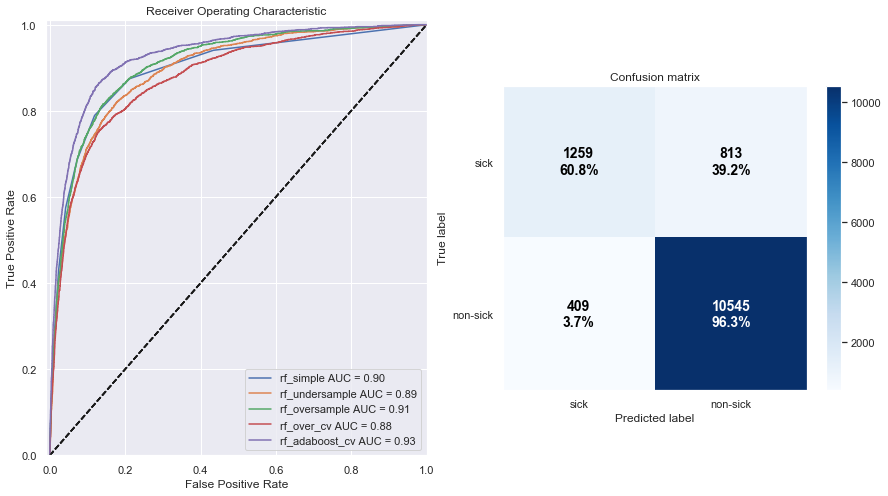

Model Scores
Actual sick rate: 15.91%
Predicted sick rate: 12.81%


,rf_simple,rf_classwts,rf_undersample,rf_oversample,rf_over_cv,rf_adaboost_cv
accuracy,0.899686,0.882969,0.842746,0.900565,0.886942,0.914582
recall,0.428071,0.689926,0.766799,0.560950,0.610015,0.581469
precision,0.752337,0.569484,0.464426,0.677070,0.596045,0.755223
f1,0.545665,0.623946,0.578483,0.613564,0.602949,0.657053
roc_auc,0.896974,0.896974,0.896974,0.896974,0.896974,0.896974
cross_entropy,0.508926,0.508926,0.508926,0.508926,0.508926,0.508926
cohen_kappa,0.515755,0.574850,0.510743,0.577207,0.558056,0.619238


In [23]:
# Show plot of metrics
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,8))
plot_roc(y_test, y_pred, y_prob, "rf_simple", ax= axes[0], sample_weights= w_test)
plot_roc(y_test, y_pred_u, y_prob_u, "rf_undersample", ax= axes[0])
plot_roc(y_test, y_pred_o, y_prob_o, "rf_oversample", ax= axes[0])
plot_roc(y_test, y_pred_cv, y_prob_cv, "rf_over_cv", ax= axes[0])
plot_roc(y_test, y_pred_ada, y_prob_ada, "rf_adaboost_cv", ax= axes[0])
plot_confusion_matrix(y_test, y_pred_ada, ax= axes[1])
plt.show()
# Store the best model
best_model = model.best_estimator_
get_metrics(y_test, y_pred_ada, 'rf_adaboost_cv', sample_weights = w_test)

The adaboost gives the best accuracy but with less recall. The f1 (a function of both recall and precision) is the best overall.

In [24]:
# Collect results in a DataFrame
cv_results = pd.DataFrame(model.cv_results_)

# Print a few interesting columns
cols = ['mean_test_score', 
        'std_test_score', 
        'mean_train_score', 
        'std_train_score',
        'param_n_estimators', 
        'param_learning_rate']
cv_results[cols].sort_values('mean_test_score', ascending=False)

/Users/valentinmonney/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/valentinmonney/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/valentinmonney/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=T

,mean_test_score,std_test_score,mean_train_score,std_train_score,param_n_estimators,param_learning_rate
3,0.912508,0.088739,0.984343,0.010411,100,0.1
2,0.911595,0.080768,0.971075,0.019424,50,0.1
1,0.898646,0.045726,0.933849,0.026865,100,0.01
0,0.892970,0.041774,0.924711,0.026317,50,0.01


No handles with labels found to put in legend.


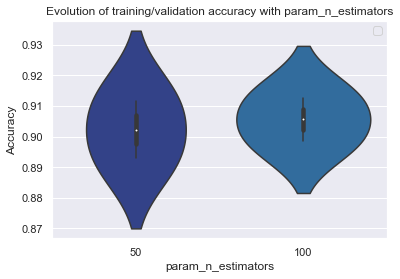

No handles with labels found to put in legend.


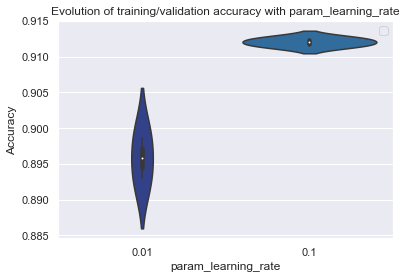

In [33]:
para = ['param_n_estimators', 'param_learning_rate']

for p in para:
    sns.violinplot(data=cv_results, x=cv_results[p], y=cv_results["mean_test_score"])
    plt.xlabel(cv_results[p].name)
    plt.ylabel('Accuracy')
    plt.title("Evolution of training/validation accuracy with {}".format(cv_results[p].name))
    plt.legend()
    plt.show()

Increasing the number of estimator reduce the variance, whereas increasing the learning rate increases the accuracy.

In [34]:
feat_imps.head(20)

,importance
Q14AGE,0.066424
expenditure_pcp,0.058043
pcnetincome,0.051900
hhsize,0.032077
Q613BED,0.023118
Q25121HIBLOOD__Yes,0.020616
Q25111MEDSER__Yes,0.016066
Q617TOILET,0.011747
Q25122SUGAR__Yes,0.010758
Q110FATHALIVE__Yes,0.010679


This time, we have the blood pressure and the age as most important feature. It also seems that Male have higher probability of being sick than Female.

# Feature selection <a class="anchor" id="feature-selection"></a>

Since this model provides feature importances, we can easily remove features that do not contribute much to the model. For example, we can filter our features to only those that contribute 80% of the model importance.

In [35]:
# Select only the features that contribute to 80% of the model importance
feats = feat_imps[feat_imps.cumsum() <= 0.80].dropna().index.values

# Select only desired features
X_train_feat = X_train[feats]
X_test_feat = X_test[feats]
print("X shape after feature selection: ", X_train_feat.shape)

# Fit the model
model = best_model
%time model.fit(X_train_feat, y_train)

# Get an initial score
%time score = model.score(X_train_feat, y_train, w_train)
print("In-sample score: {:0.2%}".format(score))
feat_imps = get_feat_imp_df(model.feature_importances_, index=X_train_feat.columns)

# Run the model
y_pred_feat = model.predict(X_test_feat)
y_prob_feat = model.predict_proba(X_test_feat)[:,1]



X shape after feature selection:  (39075, 77)
CPU times: user 3min 54s, sys: 481 ms, total: 3min 55s
Wall time: 3min 55s
CPU times: user 28.1 s, sys: 36.9 ms, total: 28.2 s
Wall time: 28.2 s
In-sample score: 97.19%


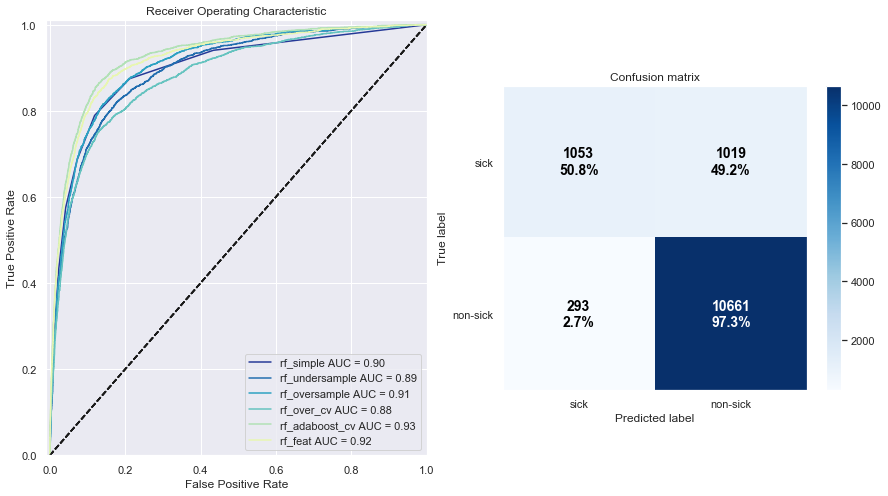

Model Scores
Actual sick rate: 15.91%
Predicted sick rate: 10.33%


,rf_simple,rf_classwts,rf_undersample,rf_oversample,rf_over_cv,rf_adaboost_cv,rf_feat
accuracy,0.899686,0.882969,0.842746,0.900565,0.886942,0.914582,0.907999
recall,0.428071,0.689926,0.766799,0.560950,0.610015,0.581469,0.470039
precision,0.752337,0.569484,0.464426,0.677070,0.596045,0.755223,0.791510
f1,0.545665,0.623946,0.578483,0.613564,0.602949,0.657053,0.589815
roc_auc,0.896974,0.896974,0.896974,0.896974,0.896974,0.896974,0.896974
cross_entropy,0.508926,0.508926,0.508926,0.508926,0.508926,0.508926,0.508926
cohen_kappa,0.515755,0.574850,0.510743,0.577207,0.558056,0.619238,0.561174


In [36]:
# Show plot of metrics
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,8))
plot_roc(y_test, y_pred, y_prob, "rf_simple", ax= axes[0], sample_weights= w_test)
plot_roc(y_test, y_pred_u, y_prob_u, "rf_undersample", ax= axes[0])
plot_roc(y_test, y_pred_o, y_prob_o, "rf_oversample", ax= axes[0])
plot_roc(y_test, y_pred_cv, y_prob_cv, "rf_over_cv", ax= axes[0])
plot_roc(y_test, y_pred_ada, y_prob_ada, "rf_adaboost_cv", ax= axes[0])
plot_roc(y_test, y_pred_feat, y_prob_feat, "rf_feat", ax= axes[0])
plot_confusion_matrix(y_test, y_pred_feat, ax= axes[1])
plt.show()
get_metrics(y_test, y_pred_feat, 'rf_feat', sample_weights = w_test)

With less than 100 features we can have roughly the same accuracy as adaboost but with significantly less recall. Interestingly, it is still better than the simple random forest algorithm. So it could be a good Idea to reduce the number of features to create simpler questionnaires.

# Random Forest Summary <a class="anchor" id="summary"></a>



In [37]:
# Inverse the cross entropy values
model_eval = model_score.copy()
model_eval[model_eval.index == 'cross_entropy'] = 1 - model_eval[model_eval.index == 'cross_entropy']

model_eval.mean().sort_values(ascending = False)

rf_adaboost_cv    0.702230
rf_classwts       0.675603
rf_oversample     0.673915
rf_feat           0.672655
rf_over_cv        0.663151
rf_undersample    0.650178
rf_simple         0.647080
dtype: float64

In [38]:
# Store the results in a pickle file
model_score.to_pickle("models/rf.pkl")